In [45]:
!pip install paddlepaddle-gpu==2.3.1 -i https://mirror.baidu.com/pypi/simple

Looking in indexes: https://mirror.baidu.com/pypi/simple


In [46]:
INSECT_NAMES = ['Boerner', 'Leconte', 'Linnaeus', 
                'acuminatus', 'armandi', 'coleoptera', 'linnaeus']

def get_insect_names():
    """
    return a dict, as following,
        {'Boerner': 0,
         'Leconte': 1,
         'Linnaeus': 2, 
         'acuminatus': 3,
         'armandi': 4,
         'coleoptera': 5,
         'linnaeus': 6
        }
    It can map the insect name into an integer label.
    """
    insect_category2id = {}
    for i, item in enumerate(INSECT_NAMES):
        insect_category2id[item] = i

    return insect_category2id

cname2cid = get_insect_names()
cname2cid

{'Boerner': 0,
 'Leconte': 1,
 'Linnaeus': 2,
 'acuminatus': 3,
 'armandi': 4,
 'coleoptera': 5,
 'linnaeus': 6}

In [47]:
import os
import numpy as np
import xml.etree.ElementTree as ET

def get_annotations(cname2cid, datadir):
    filenames = os.listdir(os.path.join(datadir, 'annotations', 'xmls'))
    records = []
    ct = 0
    for fname in filenames:
        fid = fname.split('.')[0]
        fpath = os.path.join(datadir, 'annotations', 'xmls', fname)
        img_file = os.path.join(datadir, 'images', fid + '.jpeg')
        tree = ET.parse(fpath)

        if tree.find('id') is None:
            im_id = np.array([ct])
        else:
            im_id = np.array([int(tree.find('id').text)])

        objs = tree.findall('object')
        im_w = float(tree.find('size').find('width').text)
        im_h = float(tree.find('size').find('height').text)
        gt_bbox = np.zeros((len(objs), 4), dtype=np.float32)
        gt_class = np.zeros((len(objs), ), dtype=np.int32)
        is_crowd = np.zeros((len(objs), ), dtype=np.int32)
        difficult = np.zeros((len(objs), ), dtype=np.int32)
        for i, obj in enumerate(objs):
            cname = obj.find('name').text
            gt_class[i] = cname2cid[cname]
            _difficult = int(obj.find('difficult').text)
            x1 = float(obj.find('bndbox').find('xmin').text)
            y1 = float(obj.find('bndbox').find('ymin').text)
            x2 = float(obj.find('bndbox').find('xmax').text)
            y2 = float(obj.find('bndbox').find('ymax').text)
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(im_w - 1, x2)
            y2 = min(im_h - 1, y2)
            # 这里使用xywh格式来表示目标物体真实框
            gt_bbox[i] = [(x1+x2)/2.0 , (y1+y2)/2.0, x2-x1+1., y2-y1+1.]
            is_crowd[i] = 0
            difficult[i] = _difficult

        voc_rec = {
            'im_file': img_file,
            'im_id': im_id,
            'h': im_h,
            'w': im_w,
            'is_crowd': is_crowd,
            'gt_class': gt_class,
            'gt_bbox': gt_bbox,
            'gt_poly': [],
            'difficult': difficult
            }
        if len(objs) != 0:
            records.append(voc_rec)
        ct += 1
    return records

In [48]:
TRAINDIR = '../input/insects/insects/train'
TESTDIR = '../input/insects/insects/test'
VALIDDIR = '../input/insects/insects/val'
cname2cid = get_insect_names()
records = get_annotations(cname2cid, TRAINDIR)

In [49]:
len(records),records[0]

(1693,
 {'im_file': '../input/insects/insects/train/images/1853.jpeg',
  'im_id': array([0]),
  'h': 1300.0,
  'w': 1300.0,
  'is_crowd': array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
  'gt_class': array([1, 1, 1, 0, 3, 2, 4, 5, 5], dtype=int32),
  'gt_bbox': array([[701. , 335.5, 171. , 140. ],
         [672. , 769.5, 175. , 106. ],
         [596. , 647.5, 113. , 124. ],
         [930.5, 823. , 126. , 117. ],
         [463. , 554.5,  47. ,  86. ],
         [806. , 529. ,  57. , 101. ],
         [874.5, 628. ,  70. , 101. ],
         [577.5, 537. ,  48. ,  57. ],
         [674.5, 919. ,  88. ,  55. ]], dtype=float32),
  'gt_poly': [],
  'difficult': array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)})

In [50]:
# 数据读取
import cv2

def get_bbox(gt_bbox, gt_class):
    # 对于一般的检测任务来说，一张图片上往往会有多个目标物体
    # 设置参数MAX_NUM = 50， 即一张图片最多取50个真实框；如果真实
    # 框的数目少于50个，则将不足部分的gt_bbox, gt_class和gt_score的各项数值全设置为0
    MAX_NUM = 50
    gt_bbox2 = np.zeros((MAX_NUM, 4))
    gt_class2 = np.zeros((MAX_NUM,))
    for i in range(len(gt_bbox)):
        gt_bbox2[i, :] = gt_bbox[i, :]
        gt_class2[i] = gt_class[i]
        if i >= MAX_NUM:
            break
    return gt_bbox2, gt_class2

def get_img_data_from_file(record):
    """
    record is a dict as following,
      record = {
            'im_file': img_file,
            'im_id': im_id,
            'h': im_h,
            'w': im_w,
            'is_crowd': is_crowd,
            'gt_class': gt_class,
            'gt_bbox': gt_bbox,
            'gt_poly': [],
            'difficult': difficult
            }
    """
    im_file = record['im_file']
    h = record['h']
    w = record['w']
    is_crowd = record['is_crowd']
    gt_class = record['gt_class']
    gt_bbox = record['gt_bbox']
    difficult = record['difficult']

    img = cv2.imread(im_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # check if h and w in record equals that read from img
    assert img.shape[0] == int(h), \
             "image height of {} inconsistent in record({}) and img file({})".format(
               im_file, h, img.shape[0])

    assert img.shape[1] == int(w), \
             "image width of {} inconsistent in record({}) and img file({})".format(
               im_file, w, img.shape[1])

    gt_boxes, gt_labels = get_bbox(gt_bbox, gt_class)

    # gt_bbox 用相对值
    gt_boxes[:, 0] = gt_boxes[:, 0] / float(w)
    gt_boxes[:, 1] = gt_boxes[:, 1] / float(h)
    gt_boxes[:, 2] = gt_boxes[:, 2] / float(w)
    gt_boxes[:, 3] = gt_boxes[:, 3] / float(h)
  
    return img, gt_boxes, gt_labels, (h, w)

In [51]:
record = records[0]
img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)

read image from file ../input/insects/insects/train/images/1853.jpeg


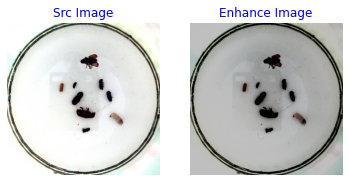

In [52]:
import numpy as np
import cv2
from PIL import Image, ImageEnhance
import random

# 随机改变亮暗、对比度和颜色等
def random_distort(img):
    # 随机改变亮度
    def random_brightness(img, lower=0.5, upper=1.5):
        e = np.random.uniform(lower, upper)
        return ImageEnhance.Brightness(img).enhance(e)
    # 随机改变对比度
    def random_contrast(img, lower=0.5, upper=1.5):
        e = np.random.uniform(lower, upper)
        return ImageEnhance.Contrast(img).enhance(e)
    # 随机改变颜色
    def random_color(img, lower=0.5, upper=1.5):
        e = np.random.uniform(lower, upper)
        return ImageEnhance.Color(img).enhance(e)

    ops = [random_brightness, random_contrast, random_color]
    np.random.shuffle(ops)

    img = Image.fromarray(img)
    img = ops[0](img)
    img = ops[1](img)
    img = ops[2](img)
    img = np.asarray(img)

    return img

# 定义可视化函数，用于对比原图和图像增强的效果
import matplotlib.pyplot as plt
def visualize(srcimg, img_enhance):
    # 图像可视化
    plt.figure(num=2, figsize=(6,12))
    plt.subplot(1,2,1)
    plt.title('Src Image', color='#0000FF')
    plt.axis('off') # 不显示坐标轴
    plt.imshow(srcimg) # 显示原图片

    # 对原图做 随机改变亮暗、对比度和颜色等 数据增强
    srcimg_gtbox = records[0]['gt_bbox']
    srcimg_label = records[0]['gt_class']

    plt.subplot(1,2,2)
    plt.title('Enhance Image', color='#0000FF')
    plt.axis('off') # 不显示坐标轴
    plt.imshow(img_enhance)



image_path = records[0]['im_file']
print("read image from file {}".format(image_path))
srcimg = Image.open(image_path)
# 将PIL读取的图像转换成array类型
srcimg = np.array(srcimg)

# 对原图做 随机改变亮暗、对比度和颜色等 数据增强
img_enhance = random_distort(srcimg)
visualize(srcimg, img_enhance)

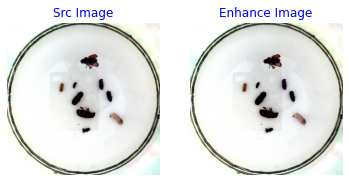

In [53]:
# 随机填充
def random_expand(img,
                  gtboxes,
                  max_ratio=4.,
                  fill=None,
                  keep_ratio=True,
                  thresh=0.5):
    if random.random() > thresh:
        return img, gtboxes

    if max_ratio < 1.0:
        return img, gtboxes

    h, w, c = img.shape
    ratio_x = random.uniform(1, max_ratio)
    if keep_ratio:
        ratio_y = ratio_x
    else:
        ratio_y = random.uniform(1, max_ratio)
    oh = int(h * ratio_y)
    ow = int(w * ratio_x)
    off_x = random.randint(0, ow - w)
    off_y = random.randint(0, oh - h)

    out_img = np.zeros((oh, ow, c))
    if fill and len(fill) == c:
        for i in range(c):
            out_img[:, :, i] = fill[i] * 255.0

    out_img[off_y:off_y + h, off_x:off_x + w, :] = img
    gtboxes[:, 0] = ((gtboxes[:, 0] * w) + off_x) / float(ow)
    gtboxes[:, 1] = ((gtboxes[:, 1] * h) + off_y) / float(oh)
    gtboxes[:, 2] = gtboxes[:, 2] / ratio_x
    gtboxes[:, 3] = gtboxes[:, 3] / ratio_y

    return out_img.astype('uint8'), gtboxes


# 对原图做 随机改变亮暗、对比度和颜色等 数据增强
srcimg_gtbox = records[0]['gt_bbox']
img_enhance, new_gtbox = random_expand(srcimg, srcimg_gtbox)
visualize(srcimg, img_enhance)

In [54]:
import numpy as np

def multi_box_iou_xywh(box1, box2):
    """
    In this case, box1 or box2 can contain multi boxes.
    Only two cases can be processed in this method:
       1, box1 and box2 have the same shape, box1.shape == box2.shape
       2, either box1 or box2 contains only one box, len(box1) == 1 or len(box2) == 1
    If the shape of box1 and box2 does not match, and both of them contain multi boxes, it will be wrong.
    """
    assert box1.shape[-1] == 4, "Box1 shape[-1] should be 4."
    assert box2.shape[-1] == 4, "Box2 shape[-1] should be 4."


    b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
    b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
    b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
    b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2

    inter_x1 = np.maximum(b1_x1, b2_x1)
    inter_x2 = np.minimum(b1_x2, b2_x2)
    inter_y1 = np.maximum(b1_y1, b2_y1)
    inter_y2 = np.minimum(b1_y2, b2_y2)
    inter_w = inter_x2 - inter_x1
    inter_h = inter_y2 - inter_y1
    inter_w = np.clip(inter_w, a_min=0., a_max=None)
    inter_h = np.clip(inter_h, a_min=0., a_max=None)

    inter_area = inter_w * inter_h
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)

    return inter_area / (b1_area + b2_area - inter_area)

def box_crop(boxes, labels, crop, img_shape):
    x, y, w, h = map(float, crop)
    im_w, im_h = map(float, img_shape)

    boxes = boxes.copy()
    boxes[:, 0], boxes[:, 2] = (boxes[:, 0] - boxes[:, 2] / 2) * im_w, (
        boxes[:, 0] + boxes[:, 2] / 2) * im_w
    boxes[:, 1], boxes[:, 3] = (boxes[:, 1] - boxes[:, 3] / 2) * im_h, (
        boxes[:, 1] + boxes[:, 3] / 2) * im_h

    crop_box = np.array([x, y, x + w, y + h])
    centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0
    mask = np.logical_and(crop_box[:2] <= centers, centers <= crop_box[2:]).all(
        axis=1)

    boxes[:, :2] = np.maximum(boxes[:, :2], crop_box[:2])
    boxes[:, 2:] = np.minimum(boxes[:, 2:], crop_box[2:])
    boxes[:, :2] -= crop_box[:2]
    boxes[:, 2:] -= crop_box[:2]

    mask = np.logical_and(mask, (boxes[:, :2] < boxes[:, 2:]).all(axis=1))
    boxes = boxes * np.expand_dims(mask.astype('float32'), axis=1)
    labels = labels * mask.astype('float32')
    boxes[:, 0], boxes[:, 2] = (boxes[:, 0] + boxes[:, 2]) / 2 / w, (
        boxes[:, 2] - boxes[:, 0]) / w
    boxes[:, 1], boxes[:, 3] = (boxes[:, 1] + boxes[:, 3]) / 2 / h, (
        boxes[:, 3] - boxes[:, 1]) / h

    return boxes, labels, mask.sum()


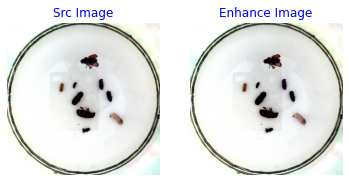

In [55]:
# 随机裁剪
def random_crop(img,
                boxes,
                labels,
                scales=[0.3, 1.0],
                max_ratio=2.0,
                constraints=None,
                max_trial=50):
    if len(boxes) == 0:
        return img, boxes

    if not constraints:
        constraints = [(0.1, 1.0), (0.3, 1.0), (0.5, 1.0), (0.7, 1.0),
                       (0.9, 1.0), (0.0, 1.0)]

    img = Image.fromarray(img)
    w, h = img.size
    crops = [(0, 0, w, h)]
    for min_iou, max_iou in constraints:
        for _ in range(max_trial):
            scale = random.uniform(scales[0], scales[1])
            aspect_ratio = random.uniform(max(1 / max_ratio, scale * scale), \
                                          min(max_ratio, 1 / scale / scale))
            crop_h = int(h * scale / np.sqrt(aspect_ratio))
            crop_w = int(w * scale * np.sqrt(aspect_ratio))
            crop_x = random.randrange(w - crop_w)
            crop_y = random.randrange(h - crop_h)
            crop_box = np.array([[(crop_x + crop_w / 2.0) / w,
                                  (crop_y + crop_h / 2.0) / h,
                                  crop_w / float(w), crop_h / float(h)]])

            iou = multi_box_iou_xywh(crop_box, boxes)
            if min_iou <= iou.min() and max_iou >= iou.max():
                crops.append((crop_x, crop_y, crop_w, crop_h))
                break

    while crops:
        crop = crops.pop(np.random.randint(0, len(crops)))
        crop_boxes, crop_labels, box_num = box_crop(boxes, labels, crop, (w, h))
        if box_num < 1:
            continue
        img = img.crop((crop[0], crop[1], crop[0] + crop[2],
                        crop[1] + crop[3])).resize(img.size, Image.LANCZOS)
        img = np.asarray(img)
        return img, crop_boxes, crop_labels
    img = np.asarray(img)
    return img, boxes, labels


# 对原图做 随机改变亮暗、对比度和颜色等 数据增强
srcimg_gtbox = records[0]['gt_bbox']
srcimg_label = records[0]['gt_class']

img_enhance, new_labels, mask = random_crop(srcimg, srcimg_gtbox, srcimg_label)
visualize(srcimg, img_enhance)

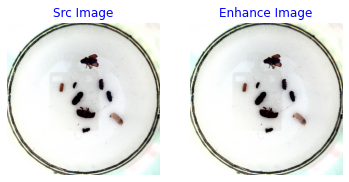

In [56]:
# 随机缩放
def random_interp(img, size, interp=None):
    interp_method = [
        cv2.INTER_NEAREST,
        cv2.INTER_LINEAR,
        cv2.INTER_AREA,
        cv2.INTER_CUBIC,
        cv2.INTER_LANCZOS4,
    ]
    if not interp or interp not in interp_method:
        interp = interp_method[random.randint(0, len(interp_method) - 1)]
    h, w, _ = img.shape
    im_scale_x = size / float(w)
    im_scale_y = size / float(h)
    img = cv2.resize(
        img, None, None, fx=im_scale_x, fy=im_scale_y, interpolation=interp)
    return img

# 对原图做 随机改变亮暗、对比度和颜色等 数据增强
img_enhance = random_interp(srcimg, 640)
visualize(srcimg, img_enhance)

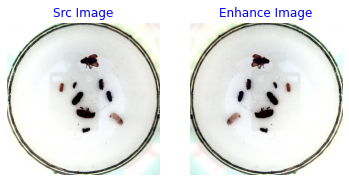

In [57]:
# 随机翻转
def random_flip(img, gtboxes, thresh=0.5):
    if random.random() > thresh:
        img = img[:, ::-1, :]
        gtboxes[:, 0] = 1.0 - gtboxes[:, 0]
    return img, gtboxes


# 对原图做 随机改变亮暗、对比度和颜色等 数据增强
img_enhance, box_enhance = random_flip(srcimg, srcimg_gtbox)
visualize(srcimg, img_enhance)

In [58]:
# 随机打乱真实框排列顺序
def shuffle_gtbox(gtbox, gtlabel):
    gt = np.concatenate(
        [gtbox, gtlabel[:, np.newaxis]], axis=1)
    idx = np.arange(gt.shape[0])
    np.random.shuffle(idx)
    gt = gt[idx, :]
    return gt[:, :4], gt[:, 4]

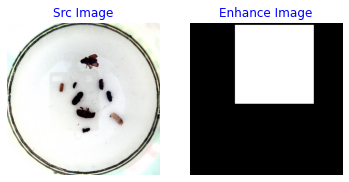

In [59]:
# 图像增广方法汇总
def image_augment(img, gtboxes, gtlabels, size, means=None):
    # 随机改变亮暗、对比度和颜色等
    img = random_distort(img)
    # 随机填充
    img, gtboxes = random_expand(img, gtboxes, fill=means)
    # 随机裁剪
    img, gtboxes, gtlabels, = random_crop(img, gtboxes, gtlabels)
    # 随机缩放
    img = random_interp(img, size)
    # 随机翻转
    img, gtboxes = random_flip(img, gtboxes)
    # 随机打乱真实框排列顺序
    gtboxes, gtlabels = shuffle_gtbox(gtboxes, gtlabels)

    return img.astype('float32'), gtboxes.astype('float32'), gtlabels.astype('int32')

img_enhance, img_box, img_label = image_augment(srcimg, srcimg_gtbox, srcimg_label, size=320)
visualize(srcimg, img_enhance)


In [60]:
img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)
size = 512
img, gt_boxes, gt_labels = image_augment(img, gt_boxes, gt_labels, size)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


In [61]:
img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)
size = 512
img, gt_boxes, gt_labels = image_augment(img, gt_boxes, gt_labels, size)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
mean = np.array(mean).reshape((1, 1, -1))
std = np.array(std).reshape((1, 1, -1))
img = (img / 255.0 - mean) / std
img = img.astype('float32').transpose((2, 0, 1))
img

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


array([[[-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
         -2.117904 , -2.117904 ],
        [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
         -2.117904 , -2.117904 ],
        [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
         -2.117904 , -2.117904 ],
        ...,
        [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
         -2.117904 , -2.117904 ],
        [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
         -2.117904 , -2.117904 ],
        [-2.117904 , -2.117904 , -2.117904 , ..., -2.117904 ,
         -2.117904 , -2.117904 ]],

       [[-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
         -2.0357144, -2.0357144],
        [-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
         -2.0357144, -2.0357144],
        [-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
         -2.0357144, -2.0357144],
        ...,
        [-2.0357144, -2.0357144, -2.0357144, ..., -2.0357144,
         -2.0357144, -2.0357144],
        [-2.

In [62]:
def get_img_data(record, size=640):
    img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)
    img, gt_boxes, gt_labels = image_augment(img, gt_boxes, gt_labels, size)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    mean = np.array(mean).reshape((1, 1, -1))
    std = np.array(std).reshape((1, 1, -1))
    img = (img / 255.0 - mean) / std
    img = img.astype('float32').transpose((2, 0, 1))
    return img, gt_boxes, gt_labels, scales

In [63]:
TRAINDIR = '../input/insects/insects/train'
TESTDIR = '../input/insects/insects/test'
VALIDDIR = '../input/insects/insects/val'
cname2cid = get_insect_names()
records = get_annotations(cname2cid, TRAINDIR)

record = records[0]
img, gt_boxes, gt_labels, scales = get_img_data(record, size=480)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


In [64]:
# 获取一个批次内样本随机缩放的尺寸
def get_img_size(mode):
    if (mode == 'train') or (mode == 'valid'):
        inds = np.array([0,1,2,3,4,5,6,7,8,9])
        ii = np.random.choice(inds)
        img_size = 320 + ii * 32
    else:
        img_size = 608
    return img_size

# 将 list形式的batch数据 转化成多个array构成的tuple
def make_array(batch_data):
    img_array = np.array([item[0] for item in batch_data], dtype = 'float32')
    gt_box_array = np.array([item[1] for item in batch_data], dtype = 'float32')
    gt_labels_array = np.array([item[2] for item in batch_data], dtype = 'int32')
    img_scale = np.array([item[3] for item in batch_data], dtype='int32')
    return img_array, gt_box_array, gt_labels_array, img_scale

In [65]:
import paddle

# 定义数据读取类，继承Paddle.io.Dataset
class TrainDataset(paddle.io.Dataset):
    def  __init__(self, datadir, mode='train'):
        self.datadir = datadir
        cname2cid = get_insect_names()
        self.records = get_annotations(cname2cid, datadir)
        self.img_size = 640  #get_img_size(mode)

    def __getitem__(self, idx):
        record = self.records[idx]
        # print("print: ", record)
        img, gt_bbox, gt_labels, im_shape = get_img_data(record, size=self.img_size)

        return img, gt_bbox, gt_labels, np.array(im_shape)

    def __len__(self):
        return len(self.records)

# 创建数据读取类
train_dataset = TrainDataset(TRAINDIR, mode='train')

# 使用paddle.io.DataLoader创建数据读取器，并设置batchsize，进程数量num_workers等参数
train_loader = paddle.io.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, drop_last=True)

In [66]:
d = paddle.io.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=1, drop_last=True)

In [67]:
img, gt_boxes, gt_labels, im_shape = next(d())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


In [68]:
img.shape, gt_boxes.shape, gt_labels.shape, im_shape.shape

([2, 3, 640, 640], [2, 50, 4], [2, 50], [2, 2])

In [69]:
import os
# 将 list形式的batch数据 转化成多个array构成的tuple
def make_test_array(batch_data):
    img_name_array = np.array([item[0] for item in batch_data])
    img_data_array = np.array([item[1] for item in batch_data], dtype = 'float32')
    img_scale_array = np.array([item[2] for item in batch_data], dtype='int32')
    return img_name_array, img_data_array, img_scale_array

# 测试数据读取
def test_data_loader(datadir, batch_size= 10, test_image_size=608, mode='test'):
    """
    加载测试用的图片，测试数据没有groundtruth标签
    """
    image_names = os.listdir(datadir)
    def reader():
        batch_data = []
        img_size = test_image_size
        for image_name in image_names:
            file_path = os.path.join(datadir, image_name)
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            H = img.shape[0]
            W = img.shape[1]
            img = cv2.resize(img, (img_size, img_size))

            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            mean = np.array(mean).reshape((1, 1, -1))
            std = np.array(std).reshape((1, 1, -1))
            out_img = (img / 255.0 - mean) / std
            out_img = out_img.astype('float32').transpose((2, 0, 1))
            img = out_img #np.transpose(out_img, (2,0,1))
            im_shape = [H, W]

            batch_data.append((image_name.split('.')[0], img, im_shape))
            if len(batch_data) == batch_size:
                yield make_test_array(batch_data)
                batch_data = []
        if len(batch_data) > 0:
            yield make_test_array(batch_data)

    return reader

In [70]:
# 标注预测框的objectness
def get_objectness_label(img, gt_boxes, gt_labels, iou_threshold = 0.7,
                         anchors = [116, 90, 156, 198, 373, 326],
                         num_classes=7, downsample=32):
    """
    img 是输入的图像数据，形状是[N, C, H, W]
    gt_boxes，真实框，维度是[N, 50, 4]，其中50是真实框数目的上限，当图片中真实框不足50个时，不足部分的坐标全为0
              真实框坐标格式是xywh，这里使用相对值
    gt_labels，真实框所属类别，维度是[N, 50]
    iou_threshold，当预测框与真实框的iou大于iou_threshold时不将其看作是负样本
    anchors，锚框可选的尺寸
    anchor_masks，通过与anchors一起确定本层级的特征图应该选用多大尺寸的锚框
    num_classes，类别数目
    downsample，特征图相对于输入网络的图片尺寸变化的比例
    """

    img_shape = img.shape
    batchsize = img_shape[0]
    num_anchors = len(anchors) // 2
    input_h = img_shape[2]
    input_w = img_shape[3]
    # 将输入图片划分成num_rows x num_cols个小方块区域，每个小方块的边长是 downsample
    # 计算一共有多少行小方块
    num_rows = input_h // downsample
    # 计算一共有多少列小方块
    num_cols = input_w // downsample

    label_objectness = np.zeros([batchsize, num_anchors, num_rows, num_cols])
    label_classification = np.zeros([batchsize, num_anchors, num_classes, num_rows, num_cols])
    label_location = np.zeros([batchsize, num_anchors, 4, num_rows, num_cols])

    scale_location = np.ones([batchsize, num_anchors, num_rows, num_cols])

    # 对batchsize进行循环，依次处理每张图片
    for n in range(batchsize):
        # 对图片上的真实框进行循环，依次找出跟真实框形状最匹配的锚框
        for n_gt in range(len(gt_boxes[n])):
            gt = gt_boxes[n][n_gt]
            gt_cls = gt_labels[n][n_gt]
            gt_center_x = gt[0]
            gt_center_y = gt[1]
            gt_width = gt[2]
            gt_height = gt[3]
            if (gt_width < 1e-3) or (gt_height < 1e-3):
                continue
            i = int(gt_center_y * num_rows)
            j = int(gt_center_x * num_cols)
            ious = []
            for ka in range(num_anchors):
                bbox1 = [0., 0., float(gt_width), float(gt_height)]
                anchor_w = anchors[ka * 2]
                anchor_h = anchors[ka * 2 + 1]
                bbox2 = [0., 0., anchor_w/float(input_w), anchor_h/float(input_h)]
                # 计算iou
                iou = box_iou_xywh(bbox1, bbox2)
                ious.append(iou)
            ious = np.array(ious)
            inds = np.argsort(ious)
            k = inds[-1]
            label_objectness[n, k, i, j] = 1
            c = gt_cls
            label_classification[n, k, c, i, j] = 1.

            # for those prediction bbox with objectness =1, set label of location
            dx_label = gt_center_x * num_cols - j
            dy_label = gt_center_y * num_rows - i
            dw_label = np.log(gt_width * input_w / anchors[k*2])
            dh_label = np.log(gt_height * input_h / anchors[k*2 + 1])
            label_location[n, k, 0, i, j] = dx_label
            label_location[n, k, 1, i, j] = dy_label
            label_location[n, k, 2, i, j] = dw_label
            label_location[n, k, 3, i, j] = dh_label
            # scale_location用来调节不同尺寸的锚框对损失函数的贡献，作为加权系数和位置损失函数相乘
            scale_location[n, k, i, j] = 2.0 - gt_width * gt_height

    # 目前根据每张图片上所有出现过的gt box，都标注出了objectness为正的预测框，剩下的预测框则默认objectness为0
    # 对于objectness为1的预测框，标出了他们所包含的物体类别，以及位置回归的目标
    return label_objectness.astype('float32'), label_location.astype('float32'), label_classification.astype('float32'), \
             scale_location.astype('float32')

In [71]:
# 计算IoU，矩形框的坐标形式为xywh
def box_iou_xywh(box1, box2):
    x1min, y1min = box1[0] - box1[2]/2.0, box1[1] - box1[3]/2.0
    x1max, y1max = box1[0] + box1[2]/2.0, box1[1] + box1[3]/2.0
    s1 = box1[2] * box1[3]

    x2min, y2min = box2[0] - box2[2]/2.0, box2[1] - box2[3]/2.0
    x2max, y2max = box2[0] + box2[2]/2.0, box2[1] + box2[3]/2.0
    s2 = box2[2] * box2[3]

    xmin = np.maximum(x1min, x2min)
    ymin = np.maximum(y1min, y2min)
    xmax = np.minimum(x1max, x2max)
    ymax = np.minimum(y1max, y2max)
    inter_h = np.maximum(ymax - ymin, 0.)
    inter_w = np.maximum(xmax - xmin, 0.)
    intersection = inter_h * inter_w

    union = s1 + s2 - intersection
    iou = intersection / union
    return iou 

In [72]:
# 读取数据
import paddle
reader = paddle.io.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=1, drop_last=True)
img, gt_boxes, gt_labels, im_shape = next(reader())
img, gt_boxes, gt_labels, im_shape = img.numpy(), gt_boxes.numpy(), gt_labels.numpy(), im_shape.numpy()

# 计算出锚框对应的标签
label_objectness, label_location, label_classification, scale_location = get_objectness_label(img,
                                                                                              gt_boxes, gt_labels, 
                                                                                              iou_threshold = 0.7,
                                                                                              anchors = [116, 90, 156, 198, 373, 326],
                                                                                              num_classes=7, downsample=32)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


In [73]:
import paddle
import paddle.nn.functional as F
import numpy as np

class ConvBNLayer(paddle.nn.Layer):
    def __init__(self, ch_in, ch_out, 
                 kernel_size=3, stride=1, groups=1,
                 padding=0, act="leaky"):
        super(ConvBNLayer, self).__init__()
    
        self.conv = paddle.nn.Conv2D(
            in_channels=ch_in,
            out_channels=ch_out,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=groups,
            weight_attr=paddle.ParamAttr(
                initializer=paddle.nn.initializer.Normal(0., 0.02)),
            bias_attr=False)
    
        self.batch_norm = paddle.nn.BatchNorm2D(
            num_features=ch_out,
            weight_attr=paddle.ParamAttr(
                initializer=paddle.nn.initializer.Normal(0., 0.02),
                regularizer=paddle.regularizer.L2Decay(0.)),
            bias_attr=paddle.ParamAttr(
                initializer=paddle.nn.initializer.Constant(0.0),
                regularizer=paddle.regularizer.L2Decay(0.)))
        self.act = act

        
    def forward(self, inputs):
        out = self.conv(inputs)
        out = self.batch_norm(out)
        if self.act == 'leaky':
            out = F.leaky_relu(x=out, negative_slope=0.1)
        return out
    
class DownSample(paddle.nn.Layer):
    # 下采样，图片尺寸减半，具体实现方式是使用stirde=2的卷积
    def __init__(self,
                 ch_in,
                 ch_out,
                 kernel_size=3,
                 stride=2,
                 padding=1):

        super(DownSample, self).__init__()

        self.conv_bn_layer = ConvBNLayer(
            ch_in=ch_in,
            ch_out=ch_out,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding)
        self.ch_out = ch_out
    def forward(self, inputs):
        out = self.conv_bn_layer(inputs)
        return out

class BasicBlock(paddle.nn.Layer):
    """
    基本残差块的定义，输入x经过两层卷积，然后接第二层卷积的输出和输入x相加
    """
    def __init__(self, ch_in, ch_out):
        super(BasicBlock, self).__init__()

        self.conv1 = ConvBNLayer(
            ch_in=ch_in,
            ch_out=ch_out,
            kernel_size=1,
            stride=1,
            padding=0
            )
        self.conv2 = ConvBNLayer(
            ch_in=ch_out,
            ch_out=ch_out*2,
            kernel_size=3,
            stride=1,
            padding=1
            )
    def forward(self, inputs):
        conv1 = self.conv1(inputs)
        conv2 = self.conv2(conv1)
        out = paddle.add(x=inputs, y=conv2)
        return out

     
class LayerWarp(paddle.nn.Layer):
    """
    添加多层残差块，组成Darknet53网络的一个层级
    """
    def __init__(self, ch_in, ch_out, count, is_test=True):
        super(LayerWarp,self).__init__()

        self.basicblock0 = BasicBlock(ch_in,
            ch_out)
        self.res_out_list = []
        for i in range(1, count):
            res_out = self.add_sublayer("basic_block_%d" % (i), # 使用add_sublayer添加子层
                BasicBlock(ch_out*2,
                    ch_out))
            self.res_out_list.append(res_out)

    def forward(self,inputs):
        y = self.basicblock0(inputs)
        for basic_block_i in self.res_out_list:
            y = basic_block_i(y)
        return y

# DarkNet 每组残差块的个数，来自DarkNet的网络结构图
DarkNet_cfg = {53: ([1, 2, 8, 8, 4])}

class DarkNet53_conv_body(paddle.nn.Layer):
    def __init__(self):
        super(DarkNet53_conv_body, self).__init__()
        self.stages = DarkNet_cfg[53]
        self.stages = self.stages[0:5]

        # 第一层卷积
        self.conv0 = ConvBNLayer(
            ch_in=3,
            ch_out=32,
            kernel_size=3,
            stride=1,
            padding=1)

        # 下采样，使用stride=2的卷积来实现
        self.downsample0 = DownSample(
            ch_in=32,
            ch_out=32 * 2)

        # 添加各个层级的实现
        self.darknet53_conv_block_list = []
        self.downsample_list = []
        for i, stage in enumerate(self.stages):
            conv_block = self.add_sublayer(
                "stage_%d" % (i),
                LayerWarp(32*(2**(i+1)),
                32*(2**i),
                stage))
            self.darknet53_conv_block_list.append(conv_block)
        # 两个层级之间使用DownSample将尺寸减半
        for i in range(len(self.stages) - 1):
            downsample = self.add_sublayer(
                "stage_%d_downsample" % i,
                DownSample(ch_in=32*(2**(i+1)),
                    ch_out=32*(2**(i+2))))
            self.downsample_list.append(downsample)

    def forward(self,inputs):
        out = self.conv0(inputs)
        #print("conv1:",out.numpy())
        out = self.downsample0(out)
        #print("dy:",out.numpy())
        blocks = []
        for i, conv_block_i in enumerate(self.darknet53_conv_block_list): #依次将各个层级作用在输入上面
            out = conv_block_i(out)
            blocks.append(out)
            if i < len(self.stages) - 1:
                out = self.downsample_list[i](out)
        return blocks[-1:-4:-1] # 将C0, C1, C2作为返回值


In [74]:
# 查看Darknet53网络输出特征图
import numpy as np
backbone = DarkNet53_conv_body()
x = np.random.randn(1, 3, 640, 640).astype('float32')
x = paddle.to_tensor(x)
C0, C1, C2 = backbone(x)
print(C0.shape, C1.shape, C2.shape)

[1, 1024, 20, 20] [1, 512, 40, 40] [1, 256, 80, 80]


In [75]:
class YoloDetectionBlock(paddle.nn.Layer):
    # define YOLOv3 detection head
    # 使用多层卷积和BN提取特征
    def __init__(self,ch_in,ch_out,is_test=True):
        super(YoloDetectionBlock, self).__init__()

        assert ch_out % 2 == 0, \
            "channel {} cannot be divided by 2".format(ch_out)

        self.conv0 = ConvBNLayer(
            ch_in=ch_in,
            ch_out=ch_out,
            kernel_size=1,
            stride=1,
            padding=0)
        self.conv1 = ConvBNLayer(
            ch_in=ch_out,
            ch_out=ch_out*2,
            kernel_size=3,
            stride=1,
            padding=1)
        self.conv2 = ConvBNLayer(
            ch_in=ch_out*2,
            ch_out=ch_out,
            kernel_size=1,
            stride=1,
            padding=0)
        self.conv3 = ConvBNLayer(
            ch_in=ch_out,
            ch_out=ch_out*2,
            kernel_size=3,
            stride=1,
            padding=1)
        self.route = ConvBNLayer(
            ch_in=ch_out*2,
            ch_out=ch_out,
            kernel_size=1,
            stride=1,
            padding=0)
        self.tip = ConvBNLayer(
            ch_in=ch_out,
            ch_out=ch_out*2,
            kernel_size=3,
            stride=1,
            padding=1)
    def forward(self, inputs):
        out = self.conv0(inputs)
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        route = self.route(out)
        tip = self.tip(route)
        return route, tip


In [76]:
NUM_ANCHORS = 3
NUM_CLASSES = 7
num_filters=NUM_ANCHORS * (NUM_CLASSES + 5)

backbone = DarkNet53_conv_body()
detection = YoloDetectionBlock(ch_in=1024, ch_out=512)
conv2d_pred = paddle.nn.Conv2D(in_channels=1024, out_channels=num_filters, kernel_size=1)

x = np.random.randn(1, 3, 640, 640).astype('float32')
x = paddle.to_tensor(x)
C0, C1, C2 = backbone(x)
route, tip = detection(C0)
P0 = conv2d_pred(tip)

print(P0.shape)

[1, 36, 20, 20]


In [77]:
NUM_ANCHORS = 3
NUM_CLASSES = 7
num_filters=NUM_ANCHORS * (NUM_CLASSES + 5)

backbone = DarkNet53_conv_body()
detection = YoloDetectionBlock(ch_in=1024, ch_out=512)
conv2d_pred = paddle.nn.Conv2D(in_channels=1024, out_channels=num_filters,  kernel_size=1)

x = np.random.randn(1, 3, 640, 640).astype('float32')
x = paddle.to_tensor(x)
C0, C1, C2 = backbone(x)
route, tip = detection(C0)
P0 = conv2d_pred(tip)

reshaped_p0 = paddle.reshape(P0, [-1, NUM_ANCHORS, NUM_CLASSES + 5, P0.shape[2], P0.shape[3]])
pred_objectness = reshaped_p0[:, :, 4, :, :]
pred_objectness_probability = F.sigmoid(pred_objectness)
print(pred_objectness.shape, pred_objectness_probability.shape)

[1, 3, 20, 20] [1, 3, 20, 20]


In [78]:
NUM_ANCHORS = 3
NUM_CLASSES = 7
num_filters=NUM_ANCHORS * (NUM_CLASSES + 5)

backbone = DarkNet53_conv_body()
detection = YoloDetectionBlock(ch_in=1024, ch_out=512)
conv2d_pred =  paddle.nn.Conv2D(in_channels=1024, out_channels=num_filters,  kernel_size=1)

x = np.random.randn(1, 3, 640, 640).astype('float32')
x = paddle.to_tensor(x)
C0, C1, C2 = backbone(x)
route, tip = detection(C0)
P0 = conv2d_pred(tip)


reshaped_p0 = paddle.reshape(P0, [-1, NUM_ANCHORS, NUM_CLASSES + 5, P0.shape[2], P0.shape[3]])
pred_objectness = reshaped_p0[:, :, 4, :, :]
pred_objectness_probability = F.sigmoid(pred_objectness)

pred_location = reshaped_p0[:, :, 0:4, :, :]
print(pred_location.shape)


[1, 3, 4, 20, 20]


In [79]:
# 定义Sigmoid函数
def sigmoid(x):
    return 1./(1.0 + np.exp(-x))

# 将网络特征图输出的[tx, ty, th, tw]转化成预测框的坐标[x1, y1, x2, y2]
def get_yolo_box_xxyy(pred, anchors, num_classes, downsample):
    """
    pred是网络输出特征图转化成的numpy.ndarray
    anchors 是一个list。表示锚框的大小，
                例如 anchors = [116, 90, 156, 198, 373, 326]，表示有三个锚框，
                第一个锚框大小[w, h]是[116, 90]，第二个锚框大小是[156, 198]，第三个锚框大小是[373, 326]
    """
    batchsize = pred.shape[0]
    num_rows = pred.shape[-2]
    num_cols = pred.shape[-1]

    input_h = num_rows * downsample
    input_w = num_cols * downsample

    num_anchors = len(anchors) // 2

    # pred的形状是[N, C, H, W]，其中C = NUM_ANCHORS * (5 + NUM_CLASSES)
    # 对pred进行reshape
    pred = pred.reshape([-1, num_anchors, 5+num_classes, num_rows, num_cols])
    pred_location = pred[:, :, 0:4, :, :]
    pred_location = np.transpose(pred_location, (0,3,4,1,2))
    anchors_this = []
    for ind in range(num_anchors):
        anchors_this.append([anchors[ind*2], anchors[ind*2+1]])
    anchors_this = np.array(anchors_this).astype('float32')
    
    # 最终输出数据保存在pred_box中，其形状是[N, H, W, NUM_ANCHORS, 4]，
    # 其中最后一个维度4代表位置的4个坐标
    pred_box = np.zeros(pred_location.shape)
    for n in range(batchsize):
        for i in range(num_rows):
            for j in range(num_cols):
                for k in range(num_anchors):
                    pred_box[n, i, j, k, 0] = j
                    pred_box[n, i, j, k, 1] = i
                    pred_box[n, i, j, k, 2] = anchors_this[k][0]
                    pred_box[n, i, j, k, 3] = anchors_this[k][1]

    # 这里使用相对坐标，pred_box的输出元素数值在0.~1.0之间
    pred_box[:, :, :, :, 0] = (sigmoid(pred_location[:, :, :, :, 0]) + pred_box[:, :, :, :, 0]) / num_cols
    pred_box[:, :, :, :, 1] = (sigmoid(pred_location[:, :, :, :, 1]) + pred_box[:, :, :, :, 1]) / num_rows
    pred_box[:, :, :, :, 2] = np.exp(pred_location[:, :, :, :, 2]) * pred_box[:, :, :, :, 2] / input_w
    pred_box[:, :, :, :, 3] = np.exp(pred_location[:, :, :, :, 3]) * pred_box[:, :, :, :, 3] / input_h

    # 将坐标从xywh转化成xyxy
    pred_box[:, :, :, :, 0] = pred_box[:, :, :, :, 0] - pred_box[:, :, :, :, 2] / 2.
    pred_box[:, :, :, :, 1] = pred_box[:, :, :, :, 1] - pred_box[:, :, :, :, 3] / 2.
    pred_box[:, :, :, :, 2] = pred_box[:, :, :, :, 0] + pred_box[:, :, :, :, 2]
    pred_box[:, :, :, :, 3] = pred_box[:, :, :, :, 1] + pred_box[:, :, :, :, 3]

    pred_box = np.clip(pred_box, 0., 1.0)

    return pred_box



In [80]:
NUM_ANCHORS = 3
NUM_CLASSES = 7
num_filters=NUM_ANCHORS * (NUM_CLASSES + 5)

backbone = DarkNet53_conv_body()
detection = YoloDetectionBlock(ch_in=1024, ch_out=512)
conv2d_pred = paddle.nn.Conv2D(in_channels=1024, out_channels=num_filters,  kernel_size=1)

x = np.random.randn(1, 3, 640, 640).astype('float32')
x = paddle.to_tensor(x)
C0, C1, C2 = backbone(x)
route, tip = detection(C0)
P0 = conv2d_pred(tip)

reshaped_p0 = paddle.reshape(P0, [-1, NUM_ANCHORS, NUM_CLASSES + 5, P0.shape[2], P0.shape[3]])
pred_objectness = reshaped_p0[:, :, 4, :, :]
pred_objectness_probability = F.sigmoid(pred_objectness)

pred_location = reshaped_p0[:, :, 0:4, :, :]

# anchors包含了预先设定好的锚框尺寸
anchors = [116, 90, 156, 198, 373, 326]
# downsample是特征图P0的步幅
pred_boxes = get_yolo_box_xxyy(P0.numpy(), anchors, num_classes=7, downsample=32) # 由输出特征图P0计算预测框位置坐标
print(pred_boxes.shape)

(1, 20, 20, 3, 4)


In [81]:
NUM_ANCHORS = 3
NUM_CLASSES = 7
num_filters=NUM_ANCHORS * (NUM_CLASSES + 5)

backbone = DarkNet53_conv_body()
detection = YoloDetectionBlock(ch_in=1024, ch_out=512)
conv2d_pred = paddle.nn.Conv2D(in_channels=1024, out_channels=num_filters,  kernel_size=1)

x = np.random.randn(1, 3, 640, 640).astype('float32')
x = paddle.to_tensor(x)
C0, C1, C2 = backbone(x)
route, tip = detection(C0)
P0 = conv2d_pred(tip)

reshaped_p0 = paddle.reshape(P0, [-1, NUM_ANCHORS, NUM_CLASSES + 5, P0.shape[2], P0.shape[3]])
# 取出与objectness相关的预测值
pred_objectness = reshaped_p0[:, :, 4, :, :]
pred_objectness_probability = F.sigmoid(pred_objectness)
# 取出与位置相关的预测值
pred_location = reshaped_p0[:, :, 0:4, :, :]
# 取出与类别相关的预测值
pred_classification = reshaped_p0[:, :, 5:5+NUM_CLASSES, :, :]
pred_classification_probability = F.sigmoid(pred_classification)
print(pred_classification.shape)

[1, 3, 7, 20, 20]


In [82]:
# 挑选出跟真实框IoU大于阈值的预测框
def get_iou_above_thresh_inds(pred_box, gt_boxes, iou_threshold):
    batchsize = pred_box.shape[0]
    num_rows = pred_box.shape[1]
    num_cols = pred_box.shape[2]
    num_anchors = pred_box.shape[3]
    ret_inds = np.zeros([batchsize, num_rows, num_cols, num_anchors])
    for i in range(batchsize):
        pred_box_i = pred_box[i]
        gt_boxes_i = gt_boxes[i]
        for k in range(len(gt_boxes_i)): #gt in gt_boxes_i:
            gt = gt_boxes_i[k]
            gtx_min = gt[0] - gt[2] / 2.
            gty_min = gt[1] - gt[3] / 2.
            gtx_max = gt[0] + gt[2] / 2.
            gty_max = gt[1] + gt[3] / 2.
            if (gtx_max - gtx_min < 1e-3) or (gty_max - gty_min < 1e-3):
                continue
            x1 = np.maximum(pred_box_i[:, :, :, 0], gtx_min)
            y1 = np.maximum(pred_box_i[:, :, :, 1], gty_min)
            x2 = np.minimum(pred_box_i[:, :, :, 2], gtx_max)
            y2 = np.minimum(pred_box_i[:, :, :, 3], gty_max)
            intersection = np.maximum(x2 - x1, 0.) * np.maximum(y2 - y1, 0.)
            s1 = (gty_max - gty_min) * (gtx_max - gtx_min)
            s2 = (pred_box_i[:, :, :, 2] - pred_box_i[:, :, :, 0]) * (pred_box_i[:, :, :, 3] - pred_box_i[:, :, :, 1])
            union = s2 + s1 - intersection
            iou = intersection / union
            above_inds = np.where(iou > iou_threshold)
            ret_inds[i][above_inds] = 1
    ret_inds = np.transpose(ret_inds, (0,3,1,2))
    return ret_inds.astype('bool')

In [83]:
def label_objectness_ignore(label_objectness, iou_above_thresh_indices):
    # 注意：这里不能简单的使用 label_objectness[iou_above_thresh_indices] = -1，
    #         这样可能会造成label_objectness为1的点被设置为-1了
    #         只有将那些被标注为0，且与真实框IoU超过阈值的预测框才被标注为-1
    negative_indices = (label_objectness < 0.5)
    ignore_indices = negative_indices * iou_above_thresh_indices
    label_objectness[ignore_indices] = -1
    return label_objectness

In [84]:
# 读取数据
reader = paddle.io.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, drop_last=True)
img, gt_boxes, gt_labels, im_shape = next(reader())
img, gt_boxes, gt_labels, im_shape = img.numpy(), gt_boxes.numpy(), gt_labels.numpy(), im_shape.numpy()
# 计算出锚框对应的标签
label_objectness, label_location, label_classification, scale_location = get_objectness_label(img,
                                                                                              gt_boxes, gt_labels, 
                                                                                              iou_threshold = 0.7,
                                                                                              anchors = [116, 90, 156, 198, 373, 326],
                                                                                              num_classes=7, downsample=32)
                                               
NUM_ANCHORS = 3
NUM_CLASSES = 7
num_filters=NUM_ANCHORS * (NUM_CLASSES + 5)

backbone = DarkNet53_conv_body()
detection = YoloDetectionBlock(ch_in=1024, ch_out=512)
conv2d_pred = paddle.nn.Conv2D(in_channels=1024, out_channels=num_filters,  kernel_size=1)

x = paddle.to_tensor(img)
C0, C1, C2 = backbone(x)
route, tip = detection(C0)
P0 = conv2d_pred(tip)

# anchors包含了预先设定好的锚框尺寸
anchors = [116, 90, 156, 198, 373, 326]
# downsample是特征图P0的步幅
pred_boxes = get_yolo_box_xxyy(P0.numpy(), anchors, num_classes=7, downsample=32)
iou_above_thresh_indices = get_iou_above_thresh_inds(pred_boxes, gt_boxes, iou_threshold=0.7)
label_objectness = label_objectness_ignore(label_objectness, iou_above_thresh_indices)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


In [85]:
def get_loss(output, label_objectness, label_location, label_classification, scales, num_anchors=3, num_classes=7):
    # 将output从[N, C, H, W]变形为[N, NUM_ANCHORS, NUM_CLASSES + 5, H, W]
    reshaped_output = paddle.reshape(output, [-1, num_anchors, num_classes + 5, output.shape[2], output.shape[3]])

    # 从output中取出跟objectness相关的预测值
    pred_objectness = reshaped_output[:, :, 4, :, :]
    loss_objectness = F.binary_cross_entropy_with_logits(pred_objectness, label_objectness, reduction="none")

    # pos_samples 只有在正样本的地方取值为1.，其它地方取值全为0.
    pos_objectness = label_objectness > 0
    pos_samples = paddle.cast(pos_objectness, 'float32')
    pos_samples.stop_gradient=True

    # 从output中取出所有跟位置相关的预测值
    tx = reshaped_output[:, :, 0, :, :]
    ty = reshaped_output[:, :, 1, :, :]
    tw = reshaped_output[:, :, 2, :, :]
    th = reshaped_output[:, :, 3, :, :]

    # 从label_location中取出各个位置坐标的标签
    dx_label = label_location[:, :, 0, :, :]
    dy_label = label_location[:, :, 1, :, :]
    tw_label = label_location[:, :, 2, :, :]
    th_label = label_location[:, :, 3, :, :]

    # 构建损失函数
    loss_location_x = F.binary_cross_entropy_with_logits(tx, dx_label, reduction="none")
    loss_location_y = F.binary_cross_entropy_with_logits(ty, dy_label, reduction="none")
    loss_location_w = paddle.abs(tw - tw_label)
    loss_location_h = paddle.abs(th - th_label)

    # 计算总的位置损失函数
    loss_location = loss_location_x + loss_location_y + loss_location_h + loss_location_w

    # 乘以scales
    loss_location = loss_location * scales
    # 只计算正样本的位置损失函数
    loss_location = loss_location * pos_samples

    # 从output取出所有跟物体类别相关的像素点
    pred_classification = reshaped_output[:, :, 5:5+num_classes, :, :]

    # 计算分类相关的损失函数
    loss_classification = F.binary_cross_entropy_with_logits(pred_classification, label_classification, reduction="none")
   
    # 将第2维求和
    loss_classification = paddle.sum(loss_classification, axis=2)
    # 只计算objectness为正的样本的分类损失函数
    loss_classification = loss_classification * pos_samples
    total_loss = loss_objectness + loss_location + loss_classification
    # 对所有预测框的loss进行求和
    total_loss = paddle.sum(total_loss, axis=[1,2,3])
    # 对所有样本求平均
    total_loss = paddle.mean(total_loss)

    return total_loss

In [86]:
from paddle.nn import Conv2D

# 计算出锚框对应的标签
label_objectness, label_location, label_classification, scale_location = get_objectness_label(img,
                                                                                              gt_boxes, gt_labels, 
                                                                                              iou_threshold = 0.7,
                                                                                              anchors = [116, 90, 156, 198, 373, 326],
                                                                                              num_classes=7, downsample=32)                                                           

NUM_ANCHORS = 3
NUM_CLASSES = 7
num_filters=NUM_ANCHORS * (NUM_CLASSES + 5)

backbone = DarkNet53_conv_body()
detection = YoloDetectionBlock(ch_in=1024, ch_out=512)
conv2d_pred = Conv2D(in_channels=1024, out_channels=num_filters,  kernel_size=1)

x = paddle.to_tensor(img)
C0, C1, C2 = backbone(x)
route, tip = detection(C0)
P0 = conv2d_pred(tip)
# anchors包含了预先设定好的锚框尺寸
anchors = [116, 90, 156, 198, 373, 326]
# downsample是特征图P0的步幅
pred_boxes = get_yolo_box_xxyy(P0.numpy(), anchors, num_classes=7, downsample=32)
iou_above_thresh_indices = get_iou_above_thresh_inds(pred_boxes, gt_boxes, iou_threshold=0.7)
label_objectness = label_objectness_ignore(label_objectness, iou_above_thresh_indices)

label_objectness = paddle.to_tensor(label_objectness)
label_location = paddle.to_tensor(label_location)
label_classification = paddle.to_tensor(label_classification)
scales = paddle.to_tensor(scale_location)
label_objectness.stop_gradient=True
label_location.stop_gradient=True
label_classification.stop_gradient=True
scales.stop_gradient=True

total_loss = get_loss(P0, label_objectness, label_location, label_classification, scales,
                          num_anchors=NUM_ANCHORS, num_classes=NUM_CLASSES)
total_loss_data = total_loss.numpy()
print(total_loss_data)


[881.4656]


In [87]:
# 定义上采样模块
class Upsample(paddle.nn.Layer):
    def __init__(self, scale=2):
        super(Upsample,self).__init__()
        self.scale = scale

    def forward(self, inputs):
        # get dynamic upsample output shape
        shape_nchw = paddle.shape(inputs)
        shape_hw = paddle.slice(shape_nchw, axes=[0], starts=[2], ends=[4])
        shape_hw.stop_gradient = True
        in_shape = paddle.cast(shape_hw, dtype='int32')
        out_shape = in_shape * self.scale
        out_shape.stop_gradient = True

        # reisze by actual_shape
        out = paddle.nn.functional.interpolate(
            x=inputs, scale_factor=self.scale, mode="NEAREST")
        return out


class YOLOv3(paddle.nn.Layer):
    def __init__(self, num_classes=7):
        super(YOLOv3,self).__init__()

        self.num_classes = num_classes
        # 提取图像特征的骨干代码
        self.block = DarkNet53_conv_body()
        self.block_outputs = []
        self.yolo_blocks = []
        self.route_blocks_2 = []
        # 生成3个层级的特征图P0, P1, P2
        for i in range(3):
            # 添加从ci生成ri和ti的模块
            yolo_block = self.add_sublayer(
                "yolo_detecton_block_%d" % (i),
                YoloDetectionBlock(
                                   ch_in=512//(2**i)*2 if i==0 else 512//(2**i)*2 + 512//(2**i),
                                   ch_out = 512//(2**i)))
            self.yolo_blocks.append(yolo_block)

            num_filters = 3 * (self.num_classes + 5)

            # 添加从ti生成pi的模块，这是一个Conv2D操作，输出通道数为3 * (num_classes + 5)
            block_out = self.add_sublayer(
                "block_out_%d" % (i),
                paddle.nn.Conv2D(in_channels=512//(2**i)*2,
                       out_channels=num_filters,
                       kernel_size=1,
                       stride=1,
                       padding=0,
                       weight_attr=paddle.ParamAttr(
                           initializer=paddle.nn.initializer.Normal(0., 0.02)),
                       bias_attr=paddle.ParamAttr(
                           initializer=paddle.nn.initializer.Constant(0.0),
                           regularizer=paddle.regularizer.L2Decay(0.))))
            self.block_outputs.append(block_out)
            if i < 2:
                # 对ri进行卷积
                route = self.add_sublayer("route2_%d"%i,
                                          ConvBNLayer(ch_in=512//(2**i),
                                                      ch_out=256//(2**i),
                                                      kernel_size=1,
                                                      stride=1,
                                                      padding=0))
                self.route_blocks_2.append(route)
            # 将ri放大以便跟c_{i+1}保持同样的尺寸
            self.upsample = Upsample()
    def forward(self, inputs):
        outputs = []
        blocks = self.block(inputs)
        for i, block in enumerate(blocks):
            if i > 0:
                # 将r_{i-1}经过卷积和上采样之后得到特征图，与这一级的ci进行拼接
                block = paddle.concat([route, block], axis=1)
            # 从ci生成ti和ri
            route, tip = self.yolo_blocks[i](block)
            # 从ti生成pi
            block_out = self.block_outputs[i](tip)
            # 将pi放入列表
            outputs.append(block_out)

            if i < 2:
                # 对ri进行卷积调整通道数
                route = self.route_blocks_2[i](route)
                # 对ri进行放大，使其尺寸和c_{i+1}保持一致
                route = self.upsample(route)

        return outputs

    def get_loss(self, outputs, gtbox, gtlabel, gtscore=None,
                 anchors = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326],
                 anchor_masks = [[6, 7, 8], [3, 4, 5], [0, 1, 2]],
                 ignore_thresh=0.7,
                 use_label_smooth=False):
        """
        使用paddle.vision.ops.yolo_loss，直接计算损失函数，过程更简洁，速度也更快
        """
        self.losses = []
        downsample = 32
        for i, out in enumerate(outputs): # 对三个层级分别求损失函数
            anchor_mask_i = anchor_masks[i]
            loss = paddle.vision.ops.yolo_loss(
                    x=out,  # out是P0, P1, P2中的一个
                    gt_box=gtbox,  # 真实框坐标
                    gt_label=gtlabel,  # 真实框类别
                    gt_score=gtscore,  # 真实框得分，使用mixup训练技巧时需要，不使用该技巧时直接设置为1，形状与gtlabel相同
                    anchors=anchors,   # 锚框尺寸，包含[w0, h0, w1, h1, ..., w8, h8]共9个锚框的尺寸
                    anchor_mask=anchor_mask_i, # 筛选锚框的mask，例如anchor_mask_i=[3, 4, 5]，将anchors中第3、4、5个锚框挑选出来给该层级使用
                    class_num=self.num_classes, # 分类类别数
                    ignore_thresh=ignore_thresh, # 当预测框与真实框IoU > ignore_thresh，标注objectness = -1
                    downsample_ratio=downsample, # 特征图相对于原图缩小的倍数，例如P0是32， P1是16，P2是8
                    use_label_smooth=False)      # 使用label_smooth训练技巧时会用到，这里没用此技巧，直接设置为False
            self.losses.append(paddle.mean(loss))  #mean对每张图片求和
            downsample = downsample // 2 # 下一级特征图的缩放倍数会减半
        return sum(self.losses) # 对每个层级求和

In [88]:
############# 这段代码在本地机器上运行请慎重，容易造成死机#######################

import time
import os
import paddle

ANCHORS = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326]

ANCHOR_MASKS = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]

IGNORE_THRESH = .7
NUM_CLASSES = 7

def get_lr(base_lr = 0.0001, lr_decay = 0.1):
    bd = [10000, 20000]
    lr = [base_lr, base_lr * lr_decay, base_lr * lr_decay * lr_decay]
    learning_rate = paddle.optimizer.lr.PiecewiseDecay(boundaries=bd, values=lr)
    return learning_rate


if __name__ == '__main__':

    TRAINDIR = '../input/insects/insects/train'
    TESTDIR = '../input/insects/insects/test'
    VALIDDIR = '../input/insects/insects/val'
    paddle.device.set_device("gpu:0")
    # 创建数据读取类
    train_dataset = TrainDataset(TRAINDIR, mode='train')
    valid_dataset = TrainDataset(VALIDDIR, mode='valid')
    test_dataset = TrainDataset(VALIDDIR, mode='valid')
    # 使用paddle.io.DataLoader创建数据读取器，并设置batchsize，进程数量num_workers等参数
    train_loader = paddle.io.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0, drop_last=True, use_shared_memory=False)
    valid_loader = paddle.io.DataLoader(valid_dataset, batch_size=10, shuffle=False, num_workers=0, drop_last=False, use_shared_memory=False)
    model = YOLOv3(num_classes = NUM_CLASSES)  #创建模型
    learning_rate = get_lr()
    opt = paddle.optimizer.Momentum(
                 learning_rate=learning_rate,
                 momentum=0.9,
                 weight_decay=paddle.regularizer.L2Decay(0.0005),
                 parameters=model.parameters())  #创建优化器
    # opt = paddle.optimizer.Adam(learning_rate=learning_rate, weight_decay=paddle.regularizer.L2Decay(0.0005), parameters=model.parameters())

    MAX_EPOCH = 200
    for epoch in range(MAX_EPOCH):
        for i, data in enumerate(train_loader()):
            img, gt_boxes, gt_labels, img_scale = data
            gt_scores = np.ones(gt_labels.shape).astype('float32')
            gt_scores = paddle.to_tensor(gt_scores)
            img = paddle.to_tensor(img)
            gt_boxes = paddle.to_tensor(gt_boxes)
            gt_labels = paddle.to_tensor(gt_labels)
            outputs = model(img)  #前向传播，输出[P0, P1, P2]
            loss = model.get_loss(outputs, gt_boxes, gt_labels, gtscore=gt_scores,
                                  anchors = ANCHORS,
                                  anchor_masks = ANCHOR_MASKS,
                                  ignore_thresh=IGNORE_THRESH,
                                  use_label_smooth=False)        # 计算损失函数

            loss.backward()    # 反向传播计算梯度
            opt.step()  # 更新参数
            opt.clear_grad()
            if i % 10 == 0:
                timestring = time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(time.time()))
                print('{}[TRAIN]epoch {}, iter {}, output loss: {}'.format(timestring, epoch, i, loss.numpy()))

        # save params of model
        if (epoch % 5 == 0) or (epoch == MAX_EPOCH -1):
            paddle.save(model.state_dict(), 'yolo_epoch{}'.format(epoch))

        # 每个epoch结束之后在验证集上进行测试
        model.eval()
        for i, data in enumerate(valid_loader()):
            img, gt_boxes, gt_labels, img_scale = data
            gt_scores = np.ones(gt_labels.shape).astype('float32')
            gt_scores = paddle.to_tensor(gt_scores)
            img = paddle.to_tensor(img)
            gt_boxes = paddle.to_tensor(gt_boxes)
            gt_labels = paddle.to_tensor(gt_labels)
            outputs = model(img)
            loss = model.get_loss(outputs, gt_boxes, gt_labels, gtscore=gt_scores,
                                  anchors = ANCHORS,
                                  anchor_masks = ANCHOR_MASKS,
                                  ignore_thresh=IGNORE_THRESH,
                                  use_label_smooth=False)
            if i % 1 == 0:
                timestring = time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(time.time()))
                print('{}[VALID]epoch {}, iter {}, output loss: {}'.format(timestring, epoch, i, loss.numpy()))
        model.train()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


2022-08-14 02:12:35[TRAIN]epoch 0, iter 0, output loss: [17516.754]
2022-08-14 02:13:05[TRAIN]epoch 0, iter 10, output loss: [680.75684]
2022-08-14 02:13:36[TRAIN]epoch 0, iter 20, output loss: [205.60916]
2022-08-14 02:14:07[TRAIN]epoch 0, iter 30, output loss: [110.581245]
2022-08-14 02:14:39[TRAIN]epoch 0, iter 40, output loss: [107.812775]
2022-08-14 02:15:12[TRAIN]epoch 0, iter 50, output loss: [84.79006]
2022-08-14 02:15:41[TRAIN]epoch 0, iter 60, output loss: [100.52647]
2022-08-14 02:16:11[TRAIN]epoch 0, iter 70, output loss: [84.81465]
2022-08-14 02:16:43[TRAIN]epoch 0, iter 80, output loss: [81.99974]
2022-08-14 02:17:13[TRAIN]epoch 0, iter 90, output loss: [62.826874]
2022-08-14 02:17:47[TRAIN]epoch 0, iter 100, output loss: [65.70698]
2022-08-14 02:18:15[TRAIN]epoch 0, iter 110, output loss: [73.10634]
2022-08-14 02:18:46[TRAIN]epoch 0, iter 120, output loss: [63.492596]
2022-08-14 02:19:20[TRAIN]epoch 0, iter 130, output loss: [74.56058]
2022-08-14 02:19:51[TRAIN]epoch 0, 

SystemError: (Fatal) Operator conv2d raises an paddle::memory::allocation::BadAlloc exception.
The exception content is
:ResourceExhaustedError: 

Out of memory error on GPU 0. Cannot allocate 500.000000MB memory on GPU 0, 15.600708GB memory has been allocated and available memory is only 305.750000MB.

Please check whether there is any other process using GPU 0.
1. If yes, please stop them, or start PaddlePaddle on another GPU.
2. If no, please decrease the batch size of your model. 
If the above ways do not solve the out of memory problem, you can try to use CUDA managed memory. The command is `export FLAGS_use_cuda_managed_memory=false`.
 (at /paddle/paddle/fluid/memory/allocation/cuda_allocator.cc:87)
. (at /paddle/paddle/fluid/imperative/tracer.cc:307)


In [ ]:
# 定义YOLOv3模型
class YOLOv3(paddle.nn.Layer):
    def __init__(self, num_classes=7):
        super(YOLOv3,self).__init__()

        self.num_classes = num_classes
        # 提取图像特征的骨干代码
        self.block = DarkNet53_conv_body()
        self.block_outputs = []
        self.yolo_blocks = []
        self.route_blocks_2 = []
        # 生成3个层级的特征图P0, P1, P2
        for i in range(3):
            # 添加从ci生成ri和ti的模块
            yolo_block = self.add_sublayer(
                "yolo_detecton_block_%d" % (i),
                YoloDetectionBlock(
                                   ch_in=512//(2**i)*2 if i==0 else 512//(2**i)*2 + 512//(2**i),
                                   ch_out = 512//(2**i)))
            self.yolo_blocks.append(yolo_block)

            num_filters = 3 * (self.num_classes + 5)

            # 添加从ti生成pi的模块，这是一个Conv2D操作，输出通道数为3 * (num_classes + 5)
            block_out = self.add_sublayer(
                "block_out_%d" % (i),
                paddle.nn.Conv2D(in_channels=512//(2**i)*2,
                       out_channels=num_filters,
                       kernel_size=1,
                       stride=1,
                       padding=0,
                       weight_attr=paddle.ParamAttr(
                           initializer=paddle.nn.initializer.Normal(0., 0.02)),
                       bias_attr=paddle.ParamAttr(
                           initializer=paddle.nn.initializer.Constant(0.0),
                           regularizer=paddle.regularizer.L2Decay(0.))))
            self.block_outputs.append(block_out)
            if i < 2:
                # 对ri进行卷积
                route = self.add_sublayer("route2_%d"%i,
                                          ConvBNLayer(ch_in=512//(2**i),
                                                      ch_out=256//(2**i),
                                                      kernel_size=1,
                                                      stride=1,
                                                      padding=0))
                self.route_blocks_2.append(route)
            # 将ri放大以便跟c_{i+1}保持同样的尺寸
            self.upsample = Upsample()
    def forward(self, inputs):
        outputs = []
        blocks = self.block(inputs)
        for i, block in enumerate(blocks):
            if i > 0:
                # 将r_{i-1}经过卷积和上采样之后得到特征图，与这一级的ci进行拼接
                block = paddle.concat([route, block], axis=1)
            # 从ci生成ti和ri
            route, tip = self.yolo_blocks[i](block)
            # 从ti生成pi
            block_out = self.block_outputs[i](tip)
            # 将pi放入列表
            outputs.append(block_out)

            if i < 2:
                # 对ri进行卷积调整通道数
                route = self.route_blocks_2[i](route)
                # 对ri进行放大，使其尺寸和c_{i+1}保持一致
                route = self.upsample(route)

        return outputs

    def get_loss(self, outputs, gtbox, gtlabel, gtscore=None,
                 anchors = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326],
                 anchor_masks = [[6, 7, 8], [3, 4, 5], [0, 1, 2]],
                 ignore_thresh=0.7,
                 use_label_smooth=False):
        """
        使用paddle.vision.ops.yolo_loss，直接计算损失函数，过程更简洁，速度也更快
        """
        self.losses = []
        downsample = 32
        for i, out in enumerate(outputs): # 对三个层级分别求损失函数
            anchor_mask_i = anchor_masks[i]
            loss = paddle.vision.ops.yolo_loss(
                    x=out,  # out是P0, P1, P2中的一个
                    gt_box=gtbox,  # 真实框坐标
                    gt_label=gtlabel,  # 真实框类别
                    gt_score=gtscore,  # 真实框得分，使用mixup训练技巧时需要，不使用该技巧时直接设置为1，形状与gtlabel相同
                    anchors=anchors,   # 锚框尺寸，包含[w0, h0, w1, h1, ..., w8, h8]共9个锚框的尺寸
                    anchor_mask=anchor_mask_i, # 筛选锚框的mask，例如anchor_mask_i=[3, 4, 5]，将anchors中第3、4、5个锚框挑选出来给该层级使用
                    class_num=self.num_classes, # 分类类别数
                    ignore_thresh=ignore_thresh, # 当预测框与真实框IoU > ignore_thresh，标注objectness = -1
                    downsample_ratio=downsample, # 特征图相对于原图缩小的倍数，例如P0是32， P1是16，P2是8
                    use_label_smooth=False)      # 使用label_smooth训练技巧时会用到，这里没用此技巧，直接设置为False
            self.losses.append(paddle.mean(loss))  #mean对每张图片求和
            downsample = downsample // 2 # 下一级特征图的缩放倍数会减半
        return sum(self.losses) # 对每个层级求和

    def get_pred(self,
                 outputs,
                 im_shape=None,
                 anchors = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326],
                 anchor_masks = [[6, 7, 8], [3, 4, 5], [0, 1, 2]],
                 valid_thresh = 0.01):
        downsample = 32
        total_boxes = []
        total_scores = []
        for i, out in enumerate(outputs):
            anchor_mask = anchor_masks[i]
            anchors_this_level = []
            for m in anchor_mask:
                anchors_this_level.append(anchors[2 * m])
                anchors_this_level.append(anchors[2 * m + 1])

            boxes, scores = paddle.vision.ops.yolo_box(
                   x=out,
                   img_size=im_shape,
                   anchors=anchors_this_level,
                   class_num=self.num_classes,
                   conf_thresh=valid_thresh,
                   downsample_ratio=downsample,
                   name="yolo_box" + str(i))
            total_boxes.append(boxes)
            total_scores.append(
                        paddle.transpose(
                        scores, perm=[0, 2, 1]))
            downsample = downsample // 2

        yolo_boxes = paddle.concat(total_boxes, axis=1)
        yolo_scores = paddle.concat(total_scores, axis=2)
        return yolo_boxes, yolo_scores

In [ ]:
# 画图展示目标物体边界框
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import imread
import math

# 定义画矩形框的程序    
def draw_rectangle(currentAxis, bbox, edgecolor = 'k', facecolor = 'y', fill=False, linestyle='-'):
    # currentAxis，坐标轴，通过plt.gca()获取
    # bbox，边界框，包含四个数值的list， [x1, y1, x2, y2]
    # edgecolor，边框线条颜色
    # facecolor，填充颜色
    # fill, 是否填充
    # linestype，边框线型
    # patches.Rectangle需要传入左上角坐标、矩形区域的宽度、高度等参数
    rect=patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1, linewidth=1,
                           edgecolor=edgecolor,facecolor=facecolor,fill=fill, linestyle=linestyle)
    currentAxis.add_patch(rect)

    
plt.figure(figsize=(10, 10))

filename = '../input/insects/insects/train/images/101.jpeg'
im = imread(filename)
plt.imshow(im)

currentAxis=plt.gca()

# 预测框位置
boxes = np.array([[4.21716537e+01, 1.28230896e+02, 2.26547668e+02, 6.00434631e+02],
       [3.18562988e+02, 1.23168472e+02, 4.79000000e+02, 6.05688416e+02],
       [2.62704697e+01, 1.39430557e+02, 2.20587097e+02, 6.38959656e+02],
       [4.24965363e+01, 1.42706665e+02, 2.25955185e+02, 6.35671204e+02],
       [2.37462646e+02, 1.35731537e+02, 4.79000000e+02, 6.31451294e+02],
       [3.19390472e+02, 1.29295090e+02, 4.79000000e+02, 6.33003845e+02],
       [3.28933838e+02, 1.22736115e+02, 4.79000000e+02, 6.39000000e+02],
       [4.44292603e+01, 1.70438187e+02, 2.26841858e+02, 6.39000000e+02],
       [2.17988785e+02, 3.02472412e+02, 4.06062927e+02, 6.29106628e+02],
       [2.00241089e+02, 3.23755096e+02, 3.96929321e+02, 6.36386108e+02],
       [2.14310303e+02, 3.23443665e+02, 4.06732849e+02, 6.35775269e+02]])

# 预测框得分
scores = np.array([0.5247661 , 0.51759845, 0.86075854, 0.9910175 , 0.39170712,
       0.9297706 , 0.5115228 , 0.270992  , 0.19087596, 0.64201415, 0.879036])

# 画出所有预测框
for box in boxes:
    draw_rectangle(currentAxis, box)


In [ ]:
# 画图展示目标物体边界框
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import imread
import math

# 定义画矩形框的程序    
def draw_rectangle(currentAxis, bbox, edgecolor = 'k', facecolor = 'y', fill=False, linestyle='-'):
    # currentAxis，坐标轴，通过plt.gca()获取
    # bbox，边界框，包含四个数值的list， [x1, y1, x2, y2]
    # edgecolor，边框线条颜色
    # facecolor，填充颜色
    # fill, 是否填充
    # linestype，边框线型
    # patches.Rectangle需要传入左上角坐标、矩形区域的宽度、高度等参数
    rect=patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1, linewidth=1,
                           edgecolor=edgecolor,facecolor=facecolor,fill=fill, linestyle=linestyle)
    currentAxis.add_patch(rect)

    
plt.figure(figsize=(10, 10))

filename = '../input/insects/insects/train/images/104.jpeg'
im = imread(filename)
plt.imshow(im)

currentAxis=plt.gca()

boxes = np.array([[4.21716537e+01, 1.28230896e+02, 2.26547668e+02, 6.00434631e+02],
       [3.18562988e+02, 1.23168472e+02, 4.79000000e+02, 6.05688416e+02],
       [2.62704697e+01, 1.39430557e+02, 2.20587097e+02, 6.38959656e+02],
       [4.24965363e+01, 1.42706665e+02, 2.25955185e+02, 6.35671204e+02],
       [2.37462646e+02, 1.35731537e+02, 4.79000000e+02, 6.31451294e+02],
       [3.19390472e+02, 1.29295090e+02, 4.79000000e+02, 6.33003845e+02],
       [3.28933838e+02, 1.22736115e+02, 4.79000000e+02, 6.39000000e+02],
       [4.44292603e+01, 1.70438187e+02, 2.26841858e+02, 6.39000000e+02],
       [2.17988785e+02, 3.02472412e+02, 4.06062927e+02, 6.29106628e+02],
       [2.00241089e+02, 3.23755096e+02, 3.96929321e+02, 6.36386108e+02],
       [2.14310303e+02, 3.23443665e+02, 4.06732849e+02, 6.35775269e+02]])
 
scores = np.array([0.5247661 , 0.51759845, 0.86075854, 0.9910175 , 0.39170712,
       0.9297706 , 0.5115228 , 0.270992  , 0.19087596, 0.64201415, 0.879036])

left_ind = np.where((boxes[:, 0]<60) * (boxes[:, 0]>20))
left_boxes = boxes[left_ind]
left_scores = scores[left_ind]

colors = ['r', 'g', 'b', 'k']

# 画出最终保留的预测框
inds = [3, 5, 10]
for i in range(3):
    box = boxes[inds[i]]
    draw_rectangle(currentAxis, box, edgecolor=colors[i])



In [ ]:
# 非极大值抑制
def nms(bboxes, scores, score_thresh, nms_thresh, pre_nms_topk, i=0, c=0):
    """
    nms
    """
    inds = np.argsort(scores)
    inds = inds[::-1]
    keep_inds = []
    while(len(inds) > 0):
        cur_ind = inds[0]
        cur_score = scores[cur_ind]
        # if score of the box is less than score_thresh, just drop it
        if cur_score < score_thresh:
            break

        keep = True
        for ind in keep_inds:
            current_box = bboxes[cur_ind]
            remain_box = bboxes[ind]
            iou = box_iou_xyxy(current_box, remain_box)
            if iou > nms_thresh:
                keep = False
                break
        if i == 0 and c == 4 and cur_ind == 951:
            print('suppressed, ', keep, i, c, cur_ind, ind, iou)
        if keep:
            keep_inds.append(cur_ind)
        inds = inds[1:]

    return np.array(keep_inds)

# 多分类非极大值抑制
def multiclass_nms(bboxes, scores, score_thresh=0.01, nms_thresh=0.45, pre_nms_topk=1000, pos_nms_topk=100):
    """
    This is for multiclass_nms
    """
    batch_size = bboxes.shape[0]
    class_num = scores.shape[1]
    rets = []
    for i in range(batch_size):
        bboxes_i = bboxes[i]
        scores_i = scores[i]
        ret = []
        for c in range(class_num):
            scores_i_c = scores_i[c]
            keep_inds = nms(bboxes_i, scores_i_c, score_thresh, nms_thresh, pre_nms_topk, i=i, c=c)
            if len(keep_inds) < 1:
                continue
            keep_bboxes = bboxes_i[keep_inds]
            keep_scores = scores_i_c[keep_inds]
            keep_results = np.zeros([keep_scores.shape[0], 6])
            keep_results[:, 0] = c
            keep_results[:, 1] = keep_scores[:]
            keep_results[:, 2:6] = keep_bboxes[:, :]
            ret.append(keep_results)
        if len(ret) < 1:
            rets.append(ret)
            continue
        ret_i = np.concatenate(ret, axis=0)
        scores_i = ret_i[:, 1]
        if len(scores_i) > pos_nms_topk:
            inds = np.argsort(scores_i)[::-1]
            inds = inds[:pos_nms_topk]
            ret_i = ret_i[inds]

        rets.append(ret_i)

    return rets

In [ ]:
# 计算IoU，矩形框的坐标形式为xyxy，这个函数会被保存在box_utils.py文件中
def box_iou_xyxy(box1, box2):
    # 获取box1左上角和右下角的坐标
    x1min, y1min, x1max, y1max = box1[0], box1[1], box1[2], box1[3]
    # 计算box1的面积
    s1 = (y1max - y1min + 1.) * (x1max - x1min + 1.)
    # 获取box2左上角和右下角的坐标
    x2min, y2min, x2max, y2max = box2[0], box2[1], box2[2], box2[3]
    # 计算box2的面积
    s2 = (y2max - y2min + 1.) * (x2max - x2min + 1.)
    
    # 计算相交矩形框的坐标
    xmin = np.maximum(x1min, x2min)
    ymin = np.maximum(y1min, y2min)
    xmax = np.minimum(x1max, x2max)
    ymax = np.minimum(y1max, y2max)
    # 计算相交矩形行的高度、宽度、面积
    inter_h = np.maximum(ymax - ymin + 1., 0.)
    inter_w = np.maximum(xmax - xmin + 1., 0.)
    intersection = inter_h * inter_w
    # 计算相并面积
    union = s1 + s2 - intersection
    # 计算交并比
    iou = intersection / union
    return iou

In [ ]:
import json
import os
ANCHORS = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326]
ANCHOR_MASKS = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
VALID_THRESH = 0.01
NMS_TOPK = 400
NMS_POSK = 100
NMS_THRESH = 0.45
NUM_CLASSES = 7

if __name__ == '__main__':
    TRAINDIR = '../input/insects/insects/train/images'
    TESTDIR = '../input/insects/insects/test/images'
    VALIDDIR = '../input/insects/insects/val/images'

    model = YOLOv3(num_classes=NUM_CLASSES)
    params_file_path = '/kaggle/working/yolo_epoch50.pdparams'
    model_state_dict = paddle.load(params_file_path)
    model.load_dict(model_state_dict)
    model.eval()

    total_results = []
    test_loader = test_data_loader(TESTDIR, batch_size= 1, mode='test')
    for i, data in enumerate(test_loader()):
        img_name, img_data, img_scale_data = data
        img = paddle.to_tensor(img_data)
        img_scale = paddle.to_tensor(img_scale_data)

        outputs = model.forward(img)
        bboxes, scores = model.get_pred(outputs,
                                 im_shape=img_scale,
                                 anchors=ANCHORS,
                                 anchor_masks=ANCHOR_MASKS,
                                 valid_thresh = VALID_THRESH)

        bboxes_data = bboxes.numpy()
        scores_data = scores.numpy()
        result = multiclass_nms(bboxes_data, scores_data,
                      score_thresh=VALID_THRESH, 
                      nms_thresh=NMS_THRESH, 
                      pre_nms_topk=NMS_TOPK, 
                      pos_nms_topk=NMS_POSK)
        for j in range(len(result)):
            result_j = result[j]
            img_name_j = img_name[j]
            total_results.append([img_name_j, result_j.tolist()])
        print('processed {} pictures'.format(len(total_results)))

    print('')
    json.dump(total_results, open('pred_results.json', 'w'))



In [ ]:
# 读取单张测试图片
def single_image_data_loader(filename, test_image_size=608, mode='test'):
    """
    加载测试用的图片，测试数据没有groundtruth标签
    """
    batch_size= 1
    def reader():
        batch_data = []
        img_size = test_image_size
        file_path = os.path.join(filename)
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        H = img.shape[0]
        W = img.shape[1]
        img = cv2.resize(img, (img_size, img_size))

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        mean = np.array(mean).reshape((1, 1, -1))
        std = np.array(std).reshape((1, 1, -1))
        out_img = (img / 255.0 - mean) / std
        out_img = out_img.astype('float32').transpose((2, 0, 1))
        img = out_img #np.transpose(out_img, (2,0,1))
        im_shape = [H, W]

        batch_data.append((image_name.split('.')[0], img, im_shape))
        if len(batch_data) == batch_size:
            yield make_test_array(batch_data)
            batch_data = []

    return reader

In [ ]:

# 定义画图函数
INSECT_NAMES = ['Boerner', 'Leconte', 'Linnaeus', 
                'acuminatus', 'armandi', 'coleoptera', 'linnaeus']

# 定义画矩形框的函数 
def draw_rectangle(currentAxis, bbox, edgecolor = 'k', facecolor = 'y', fill=False, linestyle='-'):
    # currentAxis，坐标轴，通过plt.gca()获取
    # bbox，边界框，包含四个数值的list， [x1, y1, x2, y2]
    # edgecolor，边框线条颜色
    # facecolor，填充颜色
    # fill, 是否填充
    # linestype，边框线型
    # patches.Rectangle需要传入左上角坐标、矩形区域的宽度、高度等参数
    rect=patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1, linewidth=1,
                           edgecolor=edgecolor,facecolor=facecolor,fill=fill, linestyle=linestyle)
    currentAxis.add_patch(rect)

# 定义绘制预测结果的函数
def draw_results(result, filename, draw_thresh=0.5):
    plt.figure(figsize=(10, 10))
    im = imread(filename)
    plt.imshow(im)
    currentAxis=plt.gca()
    colors = ['r', 'g', 'b', 'k', 'y', 'c', 'purple']
    for item in result:
        box = item[2:6]
        label = int(item[0])
        name = INSECT_NAMES[label]
        if item[1] > draw_thresh:
            draw_rectangle(currentAxis, box, edgecolor = colors[label])
            plt.text(box[0], box[1], name, fontsize=12, color=colors[label])

In [ ]:
import json

import paddle

ANCHORS = [10, 13, 16, 30, 33, 23, 30, 61, 62, 45, 59, 119, 116, 90, 156, 198, 373, 326]
ANCHOR_MASKS = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
VALID_THRESH = 0.01
NMS_TOPK = 400
NMS_POSK = 100
NMS_THRESH = 0.45

NUM_CLASSES = 7
if __name__ == '__main__':
    image_name = '../input/insects/insects/test/images/1915.jpeg'
    params_file_path = '/kaggle/working/yolo_epoch50.pdparams'

    model = YOLOv3(num_classes=NUM_CLASSES)
    model_state_dict = paddle.load(params_file_path)
    model.load_dict(model_state_dict)
    model.eval()

    total_results = []
    test_loader = single_image_data_loader(image_name, mode='test')
    for i, data in enumerate(test_loader()):
        img_name, img_data, img_scale_data = data
        img = paddle.to_tensor(img_data)
        img_scale = paddle.to_tensor(img_scale_data)

        outputs = model.forward(img)
        bboxes, scores = model.get_pred(outputs,
                                 im_shape=img_scale,
                                 anchors=ANCHORS,
                                 anchor_masks=ANCHOR_MASKS,
                                 valid_thresh = VALID_THRESH)

        bboxes_data = bboxes.numpy()
        scores_data = scores.numpy()
        results = multiclass_nms(bboxes_data, scores_data,
                      score_thresh=VALID_THRESH, 
                      nms_thresh=NMS_THRESH, 
                      pre_nms_topk=NMS_TOPK, 
                      pos_nms_topk=NMS_POSK)

result = results[0]
draw_results(result, image_name, draw_thresh=0.5)